dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

install mecab and neologd if you use Japanese.

install mecab on mac
```
brew install mecab mecab-ipadic  
pip install mecab-python3
```
install neologd
```
git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
cd mecab-ipadic-neologd
./bin/install-mecab-ipadic-neologd -n
```

In [ ]:
!sudo apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

In [ ]:
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git

In [ ]:
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

In [ ]:
!pip install mecab-python3 tqdm

In [4]:
import tensorflow as tf
import numpy as np
import os
import time
import sys
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from util import load_data_and_labels, get_parser


 
%matplotlib inline
%load_ext jupyternotify

build Tokenizer
get stopwords from the web site.
Japanese stopword:  あそこ, あたり, あちら ...
English stopword: ... you've, z, zero


<IPython.core.display.Javascript object>

In [5]:
class TextCNN:

    def __init__(
        self, sequence_length, num_classes, vocab_size, embedding_size, 
        filter_sizes, num_filters, l2_reg_lambda=0.0):
        print("# classes", num_classes)


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
        self.loss_weight = tf.placeholder(tf.float32, name="loss_ratio")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
      
            #　targets * -log(sigmoid(logits)) * pos_weight +　(1 - targets) * -log(1 - sigmoid(logits))
            losses = tf.nn.weighted_cross_entropy_with_logits(logits=self.scores, targets=self.input_y, pos_weight=self.loss_weight)
            #losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [6]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [7]:
files = ["data/amazon_ja/r_{}.txt".format(i) for i in range(1,6)]

In [8]:
class Tokenizer:
    def __init__(self, parser=None):
        if parser:
            self.parser = parser
        else:
            self.parser = get_parser()
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [9]:
t = Tokenizer()
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [10]:
%%notify
level= "word"#"char"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja", tokenizer=t)

start to load data and labels.
# pos:  62240
# neg:  9026
pos/neg: 6.895634832705517


<IPython.core.display.Javascript object>

In [11]:
long_doc = True

In [12]:
len(x_text)

71266

In [13]:
x_text[0][:100]

'書き込む 、 読み出し 、 転送速度 、 いずれ も 満足 です 。 1600 万 画素 の コンパクトカメラ タイプ の デジカメ に 入れる て 撮影 に 使う 、 撮影後 は カード リーダ に'

In [14]:
length_list = np.array([len(r)for r in x_text])

In [15]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,430
1,51
2,145
3,178
4,258


In [16]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,71266.000000
mean,197.862038
std,261.041825
min,4.000000
50%,134.000000
75%,228.000000
80%,261.000000
90%,373.500000
95%,535.000000
max,13936.000000


In [17]:
#df.quantile(0.95)["length"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18888dac8>]],
      dtype=object)

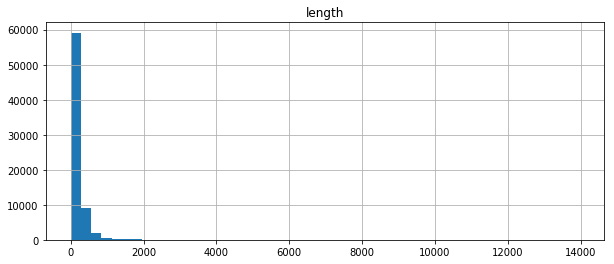

In [18]:
df.hist(bins=50,figsize=(10,4))

In [19]:
max_length = int(df.quantile(0.9)["length"]) #1000

In [20]:
#max_length = 471

In [21]:
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  373


,length
count,71266.000000
mean,165.416959
std,103.157737
min,4.000000
50%,134.000000
75%,228.000000
80%,261.000000
90%,373.000000
95%,373.000000
max,373.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1888533c8>]],
      dtype=object)

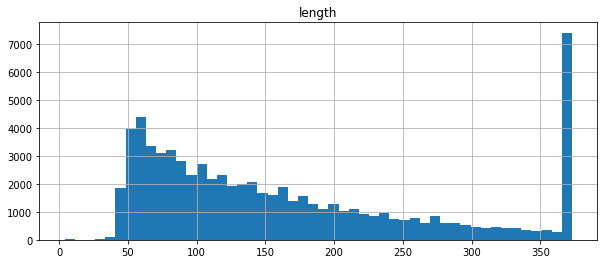

In [22]:
df.hist(bins=50,figsize=(10,4))

In [23]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [24]:
len(x_text)

71266

In [25]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [26]:
test_percentage = 0.03 #0.0010 #0.1

In [27]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 53640
Train/Test split: 69129/2137


<IPython.core.display.Javascript object>

In [28]:
print(x_train.shape)

(69129, 373)


In [29]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [30]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [31]:
embedding_size = 128    
filter_sizes = [2,3,4,5,6]    
num_filters =128               
dropout_keep_prob = 0.5 
l2_reg_lambda = 0.01       

In [33]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

# classes 2


In [32]:
batch_size = 64                  
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [ ]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", "{}_cnn_{}".format(level,num_classes), time_path, prefix)
print("Writing to {}\n".format(out_dir))

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob,
              cnn.loss_weight: 1.0#ratio
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            if step % 20 == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0,
              cnn.loss_weight: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

##char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good
- 2018_05_17_12_10_17 chABSA max_length 300
- 2018_07_07_10_13_49 amazon_ja

##word level cnn 
- 2018_05_17_12_46_51chABSA
- 2018_07_07_13_04_25 amazon_ja

## char level cnn

In [ ]:
out_dir = os.path.join("runs", "char_cnn_2","2018_07_22_22_48_46")

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt  = latest_ckpt.split("char_level_cnn/")[1]
latest_ckpt

In [ ]:
max_length = 471
vocab_size = 3215

In [ ]:
latest_ckpt  = "runs/char_cnn_2/2018_07_22_22_48_46/checkpoints/model-3940"

In [ ]:
cnn = TextCNN(
    sequence_length=max_length,
    num_classes=2,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    filter_sizes=filter_sizes,
    num_filters=num_filters)

In [ ]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        sess = tf.Session()
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                    sequence_length=max_length,
                    num_classes=2,
                    vocab_size=vocab_size,
                    embedding_size=embedding_size,
                    filter_sizes=filter_sizes,
                    num_filters=num_filters)
            
            saver = tf.train.Saver()
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [ ]:
rev = """
これは全然ダメです。使えません。
こんな商品を買うんじゃなかった・・・
後悔しています。皆さんも買わない方が良いです。
"""
check_neg_posi(rev)

In [ ]:
rev = """
サイコーです！今まで多くの類似商品を買ってきましたが、これほど良いものには出会ったことありません。
これからも使い続けたいと思います(*ﾟ▽ﾟ*)
"""
check_neg_posi(rev)

In [38]:
def eval_acc(x, y, max_length):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            
            saver = tf.train.Saver()
            saver.restore(sess, latest_ckpt)
        
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
    return acc, scores

In [ ]:
def drop_char(x_test ,n):
    drop_x_test = []
    for x in  x_test:
        x_c = x.copy()
        for i in choice(range(max_length), n,replace=False):
            x_c[i] = randint(max_length)
        drop_x_test.append(x_c)
    return drop_x_test

In [ ]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
a,s = eval_acc(drop_char(x_test, 10), y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [ ]:
len(s)

In [ ]:
s.shape

In [ ]:
y_test.shape

In [ ]:
len(y_test)

In [47]:
max_change_leng = 100

In [ ]:
r = []
for i in tqdm(range(max_change_leng)):
    a,s = eval_acc(drop_char(x_test, i), y_test, max_length=max_length)
    print(a)
    r.append(a)

In [ ]:
plt.plot(range(max_change_leng), r)
plt.show()

## word level

In [34]:
out_dir = os.path.join("runs", "word_cnn_2","2018_07_25_14_46_48")

In [35]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path
latest_ckpt  = latest_ckpt.split("char_level_cnn/")[1]
latest_ckpt

'runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040'

In [50]:
max_length = 373
vocab_size = 53640

In [39]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
acc:  0.9405709
             precision    recall  f1-score   support

        neg     0.8465    0.6404    0.7292       267
        pos     0.9504    0.9834    0.9666      1870

avg / total     0.9374    0.9406    0.9370      2137



In [40]:
def create_drop_doc(positive_data_file, negative_data_file, n):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    po = []
    ne = []
    t = Tokenizer()
    for e in positive_examples:
        if len(e) < n:
            e_ = ""
            for _ in  range(len(e)):
                e_ += chr(randint(12354, 20000)) + " "
            e = e_
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        po.append(t.tokenize(e))
        
    for e in negative_examples:
        if len(e) < n:
            e = "{} ".format(chr(randint(12354, 20000))) * len(e)
        else:
            max_n = n
            for i in choice(range(len(e)), max_n, replace=False):
                e = e.replace(e[i], chr(randint(12354, 20000)))
        ne.append(t.tokenize(e))

   
    positive_examples = po
    negative_examples = ne
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    #return po, y
    return x_text, y

In [41]:
x_, y_ = create_drop_doc(positive_data_file, negative_data_file, 300)

In [42]:
x_[1]

'䄏 ㇖ 㕲 ㇗ 䯿 䯄 䧝 䭻 䡕 䞑 䍦 㥹 㔆 ㌲ 䊂 䑹 ㋃ 㿋 䮈 䤭 䝞 㢊 㢂 ㄟ 䴿 㜍 䆸 㷐 䵫 䱅 䉄 䈀 䛮'

In [43]:
x = np.array(list(vocab_processor.fit_transform(x_)))

In [44]:
x = x[shuffle_indices][test_sample_index:]

In [45]:
a,s = eval_acc(x_test, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
acc:  0.9405709
             precision    recall  f1-score   support

        neg     0.8465    0.6404    0.7292       267
        pos     0.9504    0.9834    0.9666      1870

avg / total     0.9374    0.9406    0.9370      2137



In [ ]:
a,s = eval_acc(x, y_test, max_length=max_length)
print("acc: ", a)
print(classification_report([v.argmax() for v in y_test], [v.argmax() for v in s], digits=4 ,target_names=["neg", "pos"]))

In [48]:
max_change_leng = 100

In [52]:
r = []
for i in tqdm(range(max_change_leng)):
    x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
    x = np.array(list(vocab_processor.fit_transform(x_)))
    x = x[shuffle_indices][test_sample_index:]
    a,s = eval_acc(x, y_test,max_length=max_length)
    print(a)
    r.append(a)

# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040


HBox(children=(IntProgress(value=0), HTML(value='')))

InvalidArgumentError: Incompatible shapes: [2137] vs. [71266]
	 [[Node: accuracy/Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fc-3/predictions, accuracy/ArgMax)]]

Caused by op 'accuracy/Equal', defined at:
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-990e0a9714ea>", line 12, in <module>
    l2_reg_lambda=l2_reg_lambda)
  File "<ipython-input-5-a205570fab05>", line 82, in __init__
    correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2529, in equal
    "Equal", x=x, y=y, name=name)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [2137] vs. [71266]
	 [[Node: accuracy/Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fc-3/predictions, accuracy/ArgMax)]]


In [ ]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        saver.restore(sess, latest_ckpt)
        for i in tqdm(range(max_change_leng)):
            x_, y_ = create_drop_doc(positive_data_file, negative_data_file, i)
            x = np.array(list(vocab_processor.fit_transform(x_)))
            x = x[shuffle_indices][test_sample_index:]
            feed_dict = {
              cnn.input_x: x,
              cnn.input_y: y_test,
              cnn.dropout_keep_prob: 1.0
            }
            acc, scores = sess.run([cnn.accuracy, cnn.scores], feed_dict=feed_dict)
            a,s = eval_acc(x, y_test,max_length=max_length)
            print(a)
            r.append(a)

# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040


HBox(children=(IntProgress(value=0), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tamoto.yoshifumi/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.94337857
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.9405709
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.931212
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.9279364
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.92185307
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.91576976
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.9110903
# classes 2
INFO:tensorflow:Restoring parameters from runs/word_cnn_2/2018_07_25_14_46_48/checkpoints/model-2040
0.905007
# classes 2
INF

In [ ]:
plt.plot(range(max_change_leng), r)
plt.show()

In [ ]:
a,s = eval_acc(drop_char(), y_test, max_length=max_length)
a

In [ ]:
#out_dir="runs/1523936751"

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        #sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))